In [1]:
import numpy as np  # generic math functions
import plotly.graph_objects as go
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
from quspin.operators import hamiltonian

In [46]:
from IPython.display import HTML, display
from plotly.offline import init_notebook_mode

init_notebook_mode()
display(
    HTML(
        '<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.2.2/es5/tex-mml-svg.min.js" integrity="sha512-4MXl9OmsJPCU3LySQiKq4baSCSNFha8CBJL7NVSmN+WJJNLhJUycJgGdxJlxAY2ih8jhP9juGYq2ThUihYBKIw==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>'  # noqa: E501
    )
)

In [2]:
import plotly.io as pio

pio.renderers.default = "png"

In [3]:
g = (np.sqrt(5) + 5) / 8
h = (np.sqrt(5) + 1) / 4
J = 1

In [4]:
def compute_mat(L, center=-0.25, window=0.01):
    basis = spin_basis_1d(L=L, kblock=0, pblock=+1)

    with open(f"data/eig/L={L}/L={L}_k=0_p=+1.npy", "rb") as f:
        energies = np.load(f)
        eigenstates = np.load(f)

    energy_densities = energies / L
    mask = (center - window < energy_densities) & (energy_densities < center + window)
    energy_densities = energy_densities[mask]
    eigenstates = eigenstates[:, mask]

    op = hamiltonian([["x", [[1, i] for i in range(L)]]], [], basis=basis)

    mat = (
        np.abs(
            op.matrix_ele(
                eigenstates,
                eigenstates,
            )
        )
        / L
    )

    return energy_densities, mat

In [5]:
energy_densities, mat = compute_mat(18, window=0.0146)

Hermiticity check passed!
Symmetry checks passed!


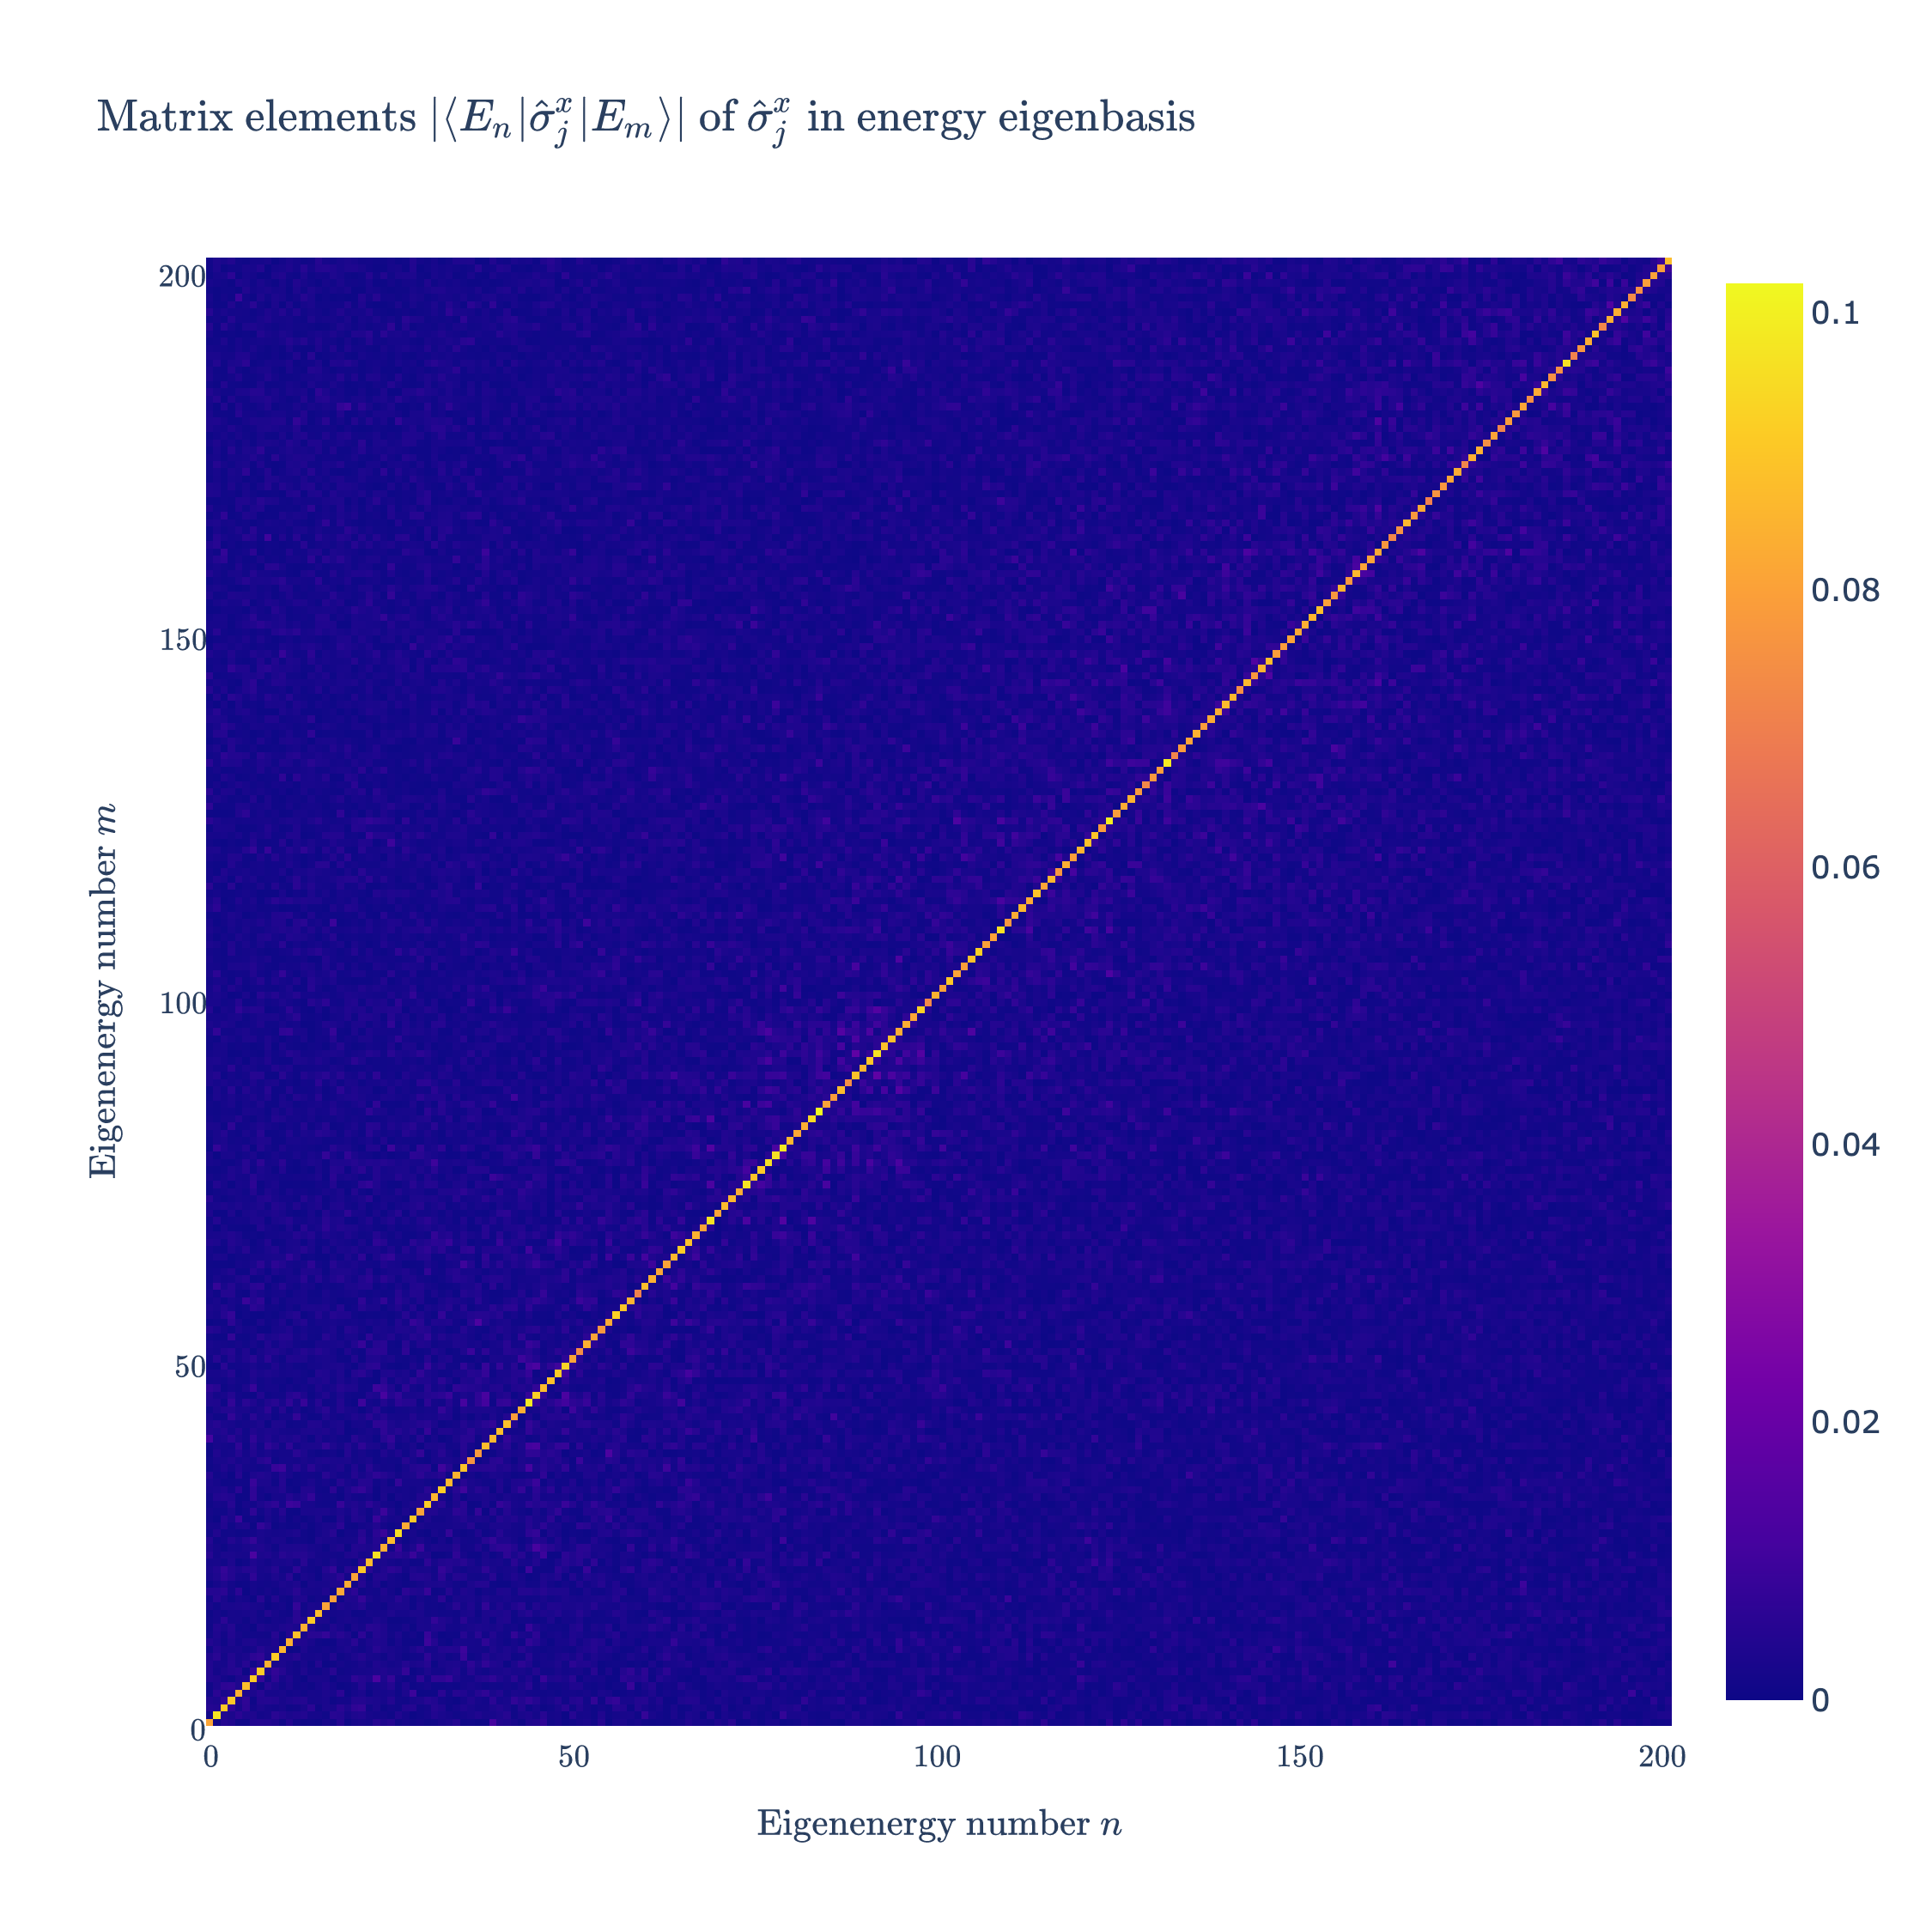

In [6]:
figure = go.Figure(data=go.Heatmap(z=mat))

figure.update_layout(
    width=750,
    height=750,
    xaxis=dict(
        title=r"$\text{Eigenenergy number }n$",
        # range=[-0.3, 0.3],
        tickprefix="$",
        ticksuffix="$",
    ),
    yaxis=dict(
        title=r"$\text{Eigenenergy number }m$",
        # range=[-0.2, 0.2],
        tickprefix="$",
        ticksuffix="$",
    ),
    title=r"$\text{Matrix elements }|\langle E_n|\hat\sigma^x_j|E_m\rangle|\text{ of }\hat\sigma^x_j\text{ in energy eigenbasis}$",
)

figure.show(scale=3)

In [7]:
energy_densities, mat = compute_mat(18, center=0, window=0.5)

energy_density_difference = (
    energy_densities[:, np.newaxis] - energy_densities[np.newaxis, :]
)[np.tril_indices(energy_densities.size, k=-1)]

matrix_elements = mat[np.tril_indices(mat.shape[0], k=-1)]

order = np.argsort(energy_density_difference)
energy_density_difference = energy_density_difference[order]
matrix_elements = matrix_elements[order]

matrix_elements_avg = np.convolve(matrix_elements, np.ones(50) / 50, mode="same")

Hermiticity check passed!
Symmetry checks passed!


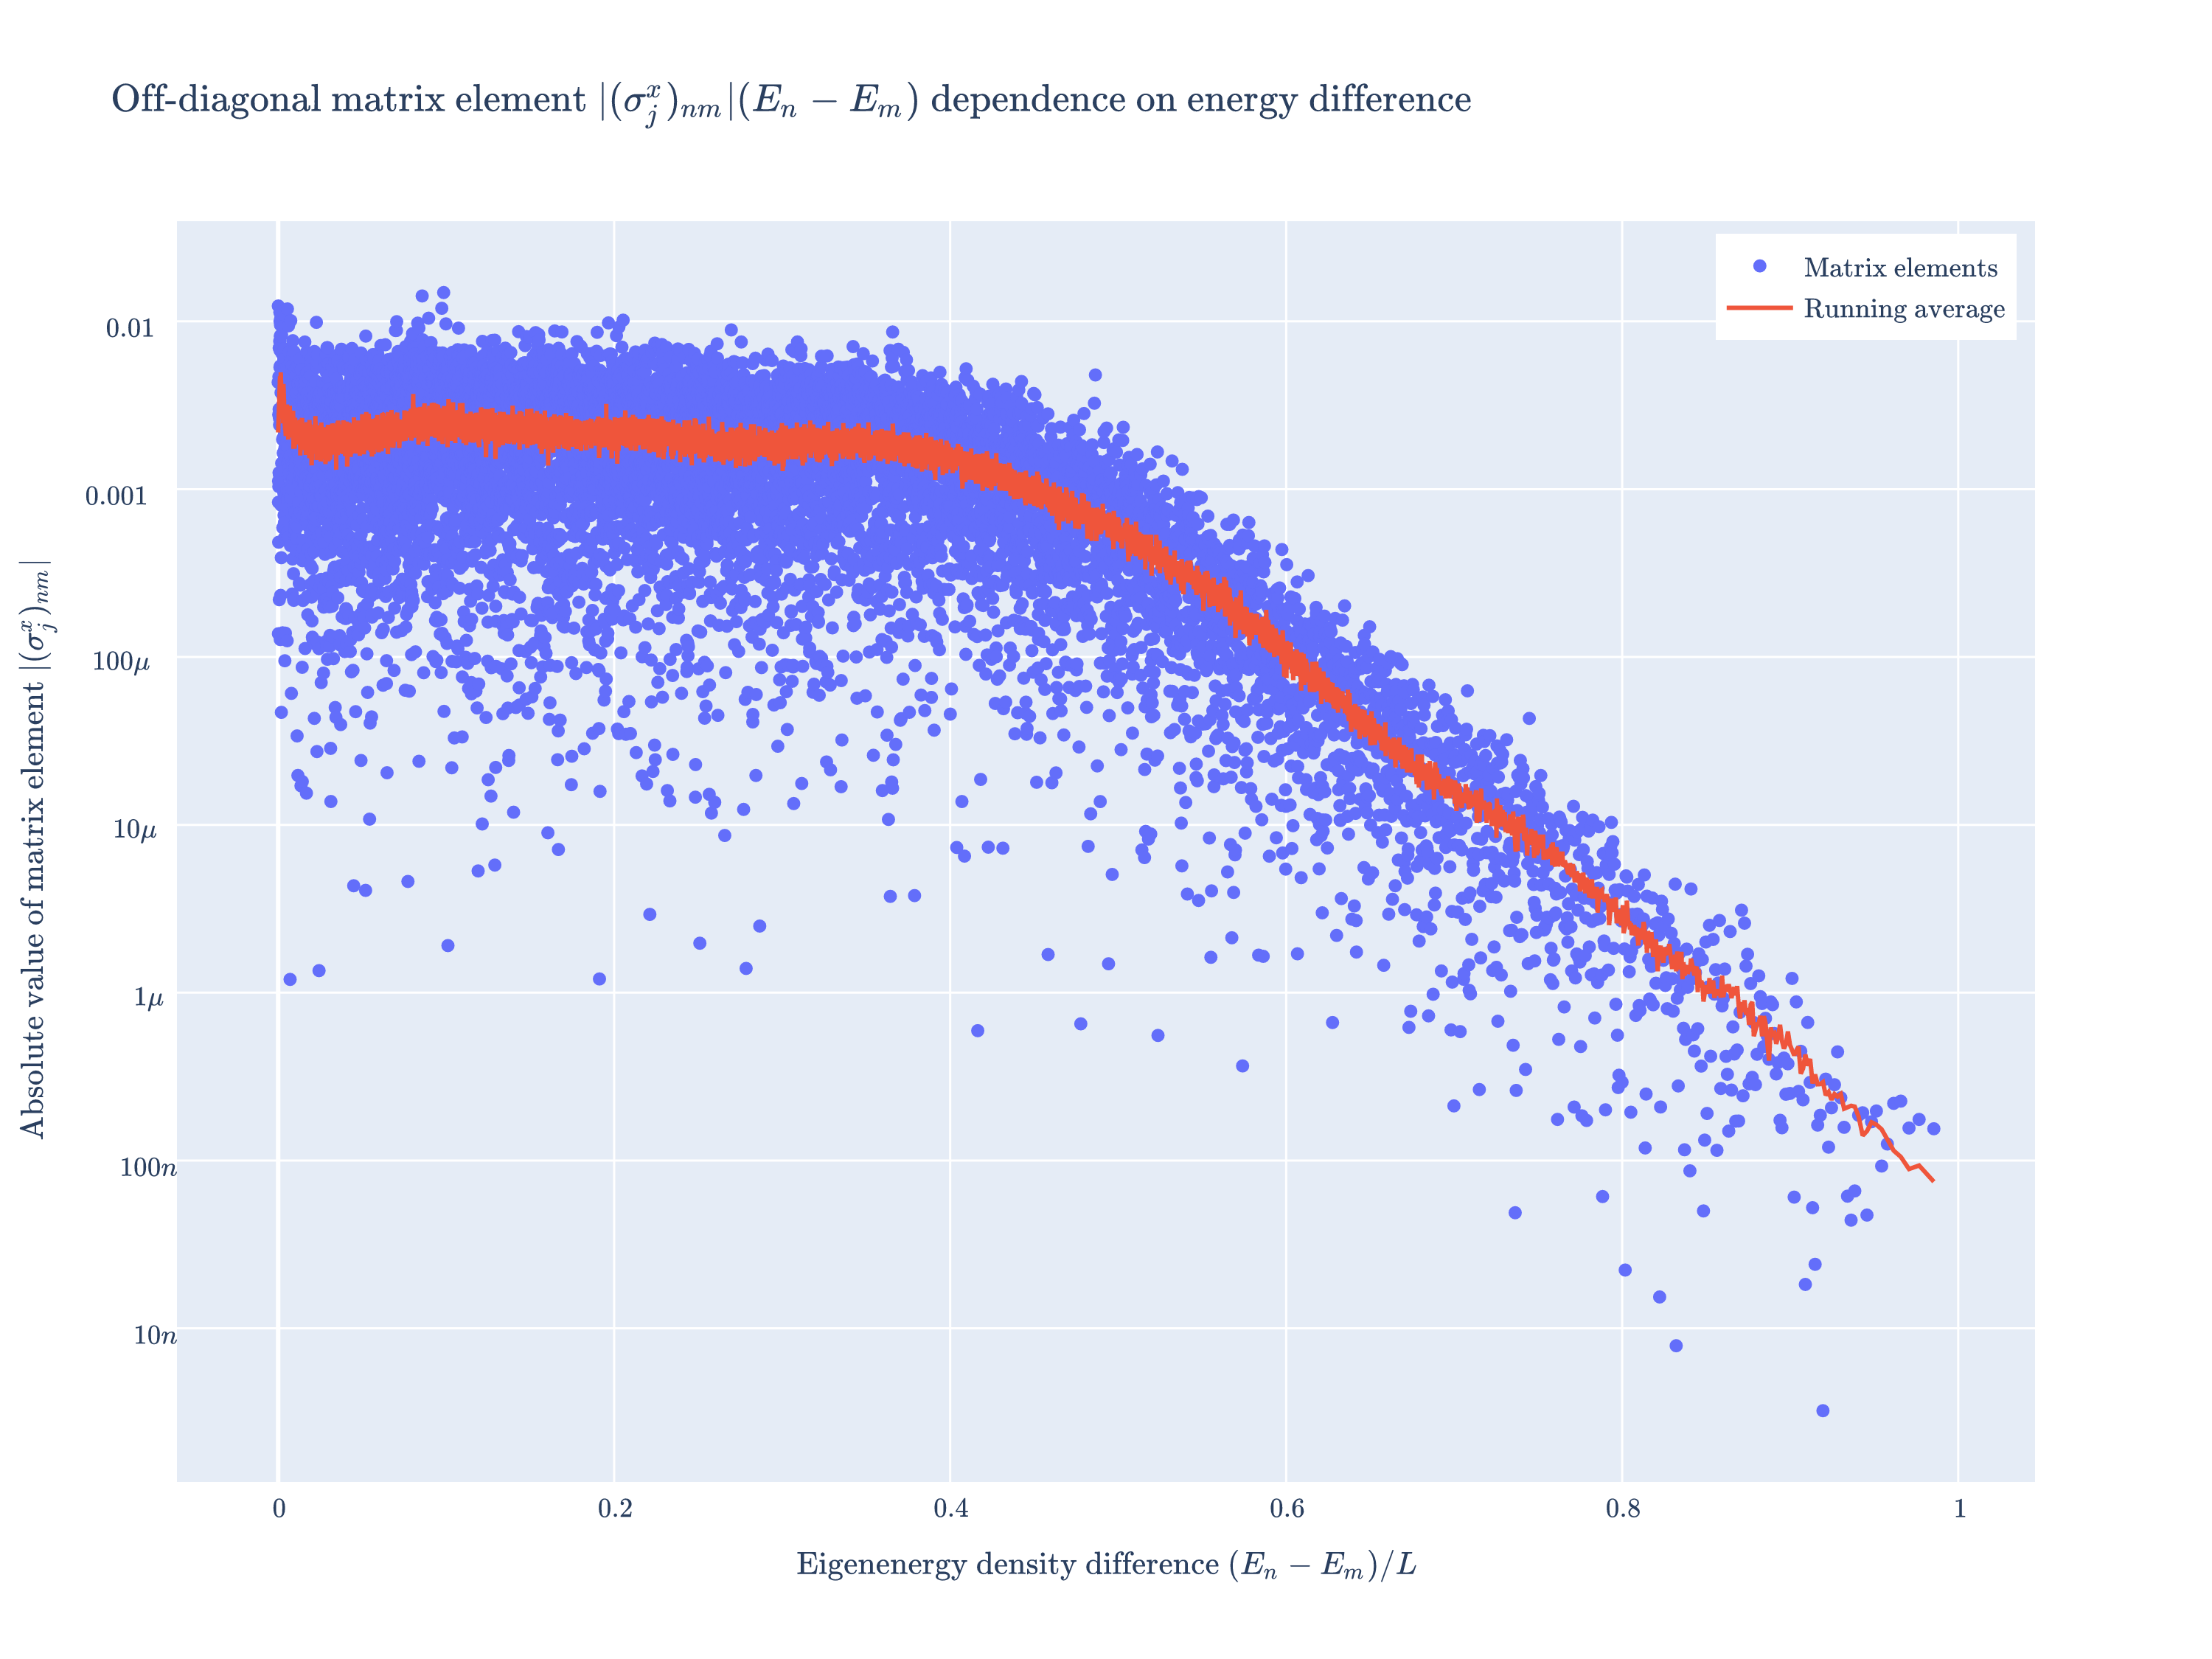

In [8]:
n = round(energy_density_difference.shape[0] / 10000)

figure = go.Figure(
    data=[
        go.Scatter(
            x=energy_density_difference[::n],
            y=matrix_elements[::n],
            mode="markers",
            name=r"$\text{Matrix elements}$",
        ),
        go.Scatter(
            x=energy_density_difference[::n],
            y=matrix_elements_avg[::n],
            name=r"$\text{Running average}$",
        ),
    ]
)

figure.update_layout(
    width=1000,
    height=750,
    xaxis=dict(
        title=r"$\text{Eigenenergy density difference }(E_n-E_m)/L$",
        # range=[-0.3, 0.3],
        tickprefix="$",
        ticksuffix="$",
    ),
    yaxis=dict(
        title=r"$\text{Absolute value of matrix element }|(\sigma^x_j)_{nm}|$",
        # range=[-0.2, 0.2],
        type="log",
        tickprefix="$",
        ticksuffix="$",
    ),
    title=r"$\text{Off-diagonal matrix element }|(\sigma^x_j)_{nm}|(E_n-E_m)\text{ dependence on energy difference}$",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
    ),
)

figure.show(scale=3)

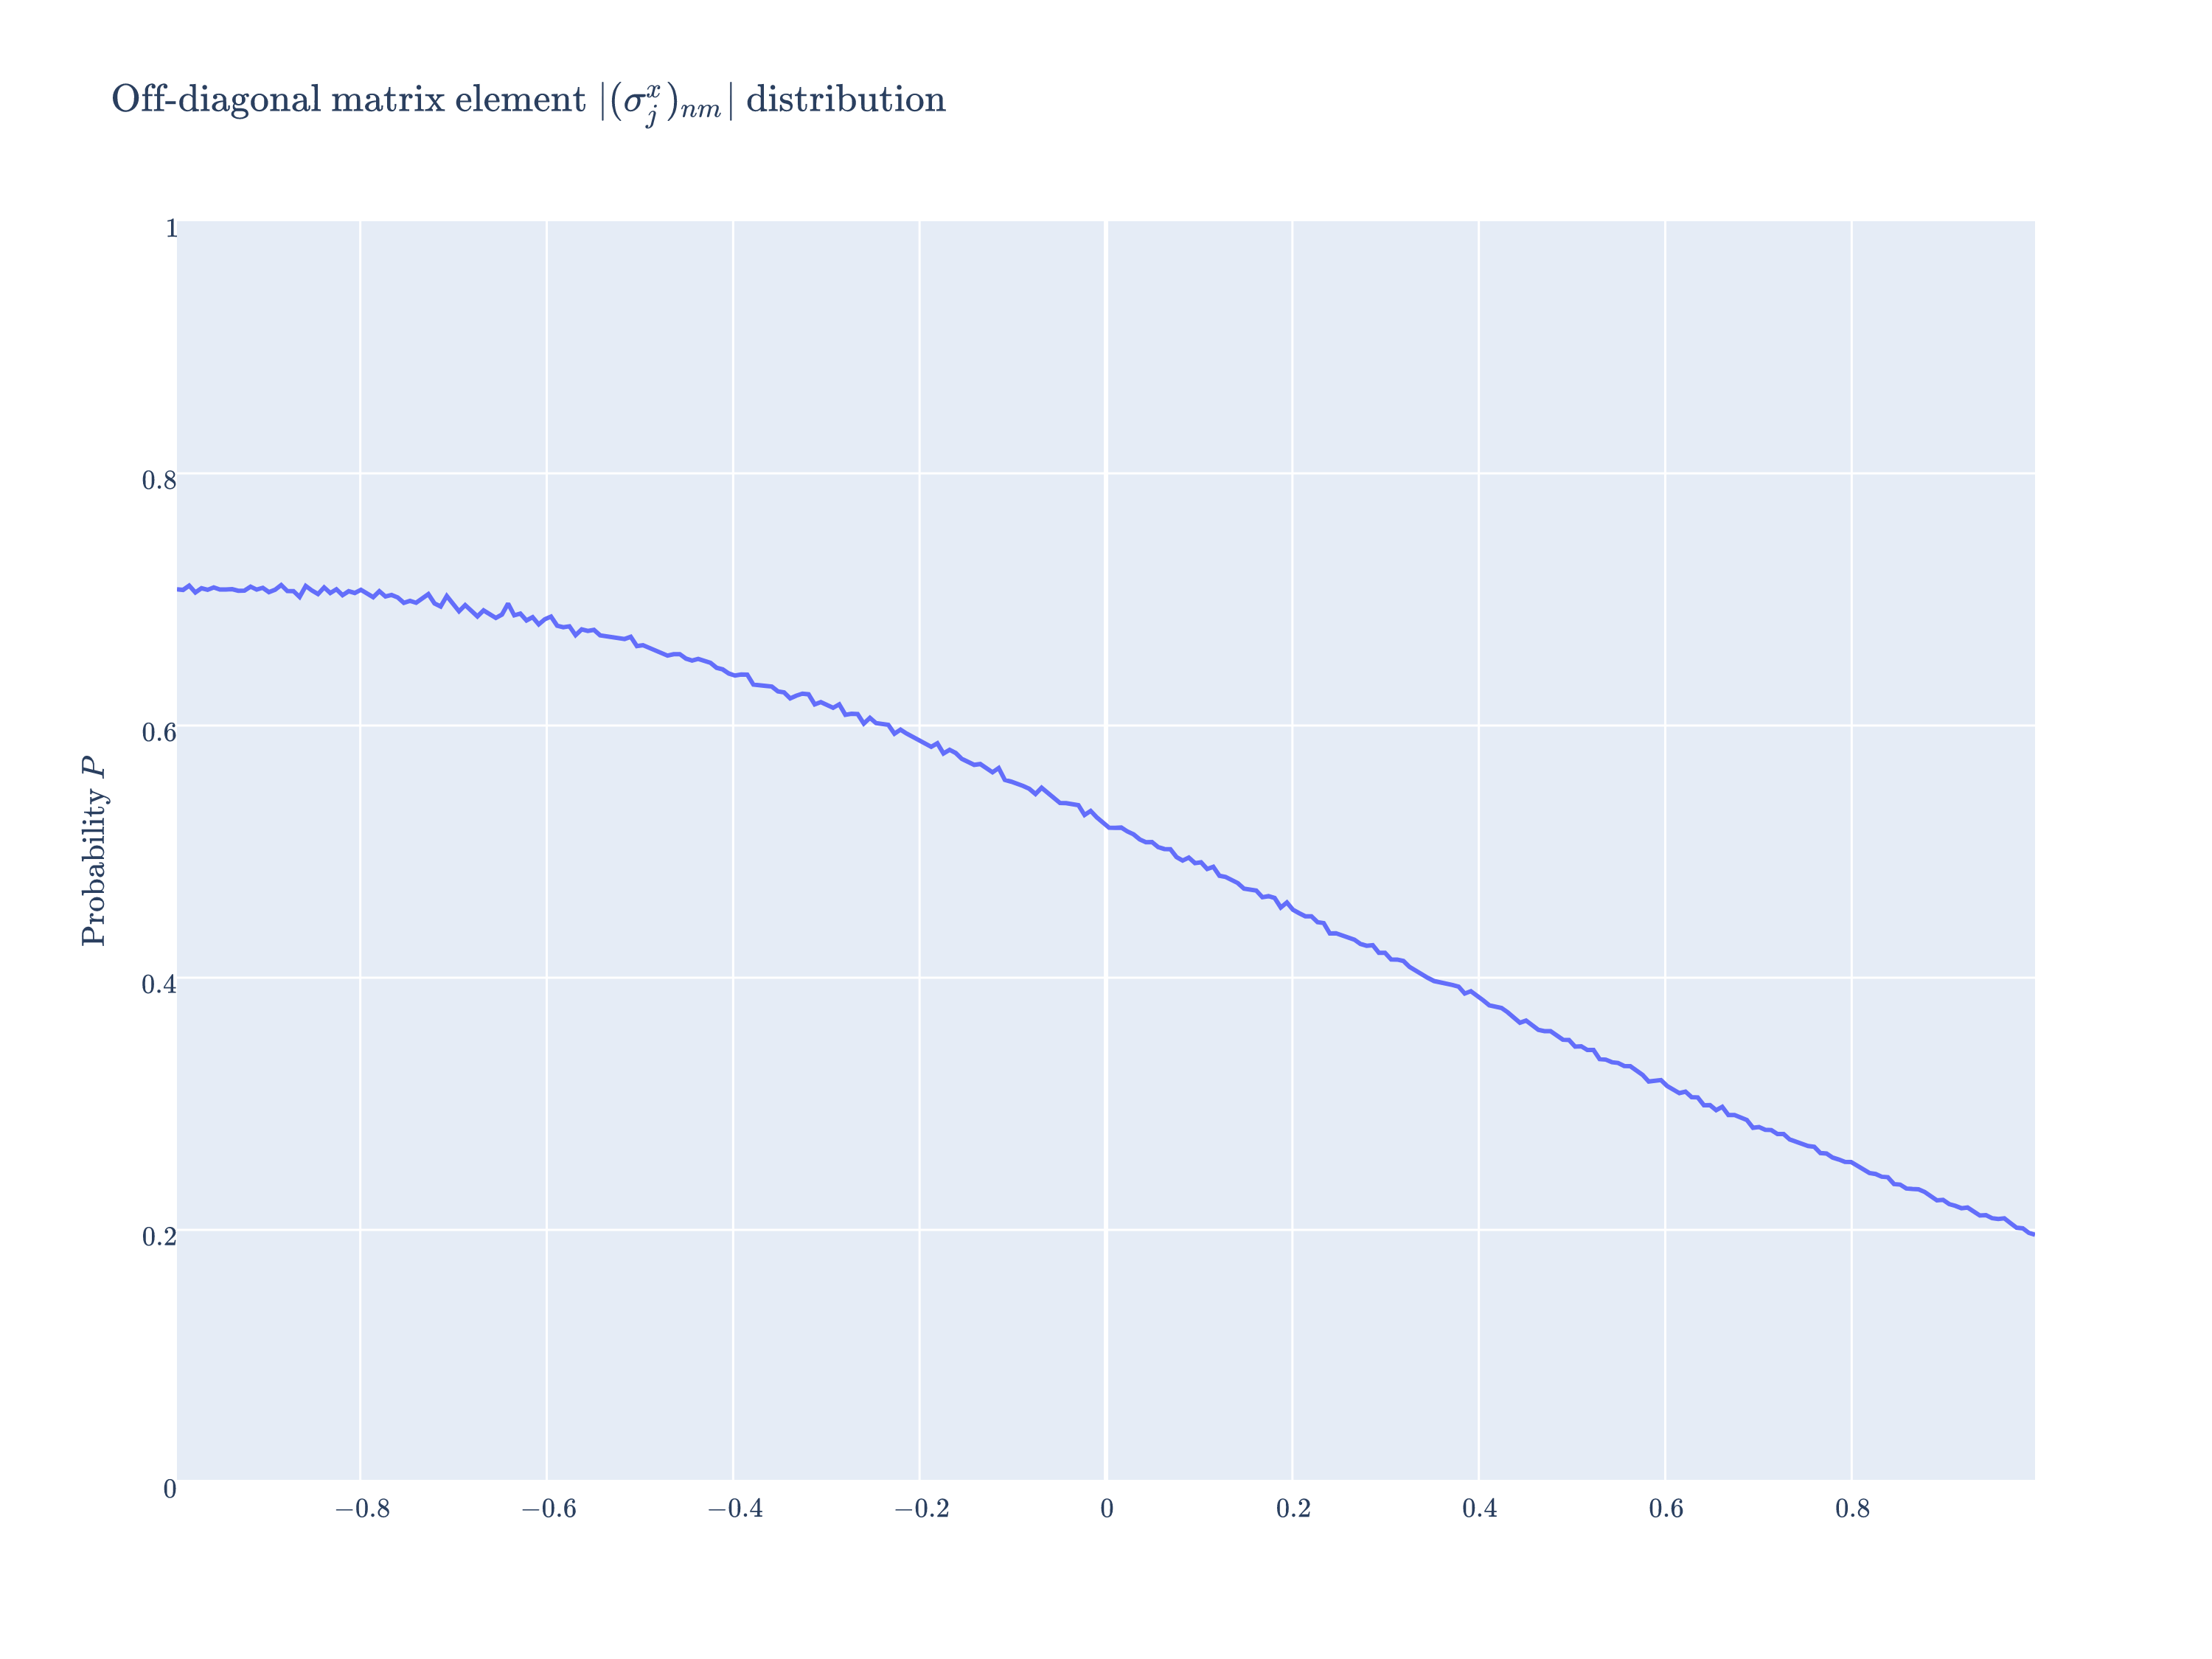

In [9]:
hist, bin_edges = np.histogram(
    (matrix_elements - matrix_elements_avg) / matrix_elements_avg,
    # matrix_elements - matrix_elements_avg,
    bins="auto",
    density=True,
    range=[-1, +1],
)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

figure = go.Figure(data=go.Scatter(x=bin_centers, y=hist))

figure.update_layout(
    width=1000,
    height=750,
    xaxis=dict(
        title=r"$\text{Relative difference}}$",
        tickprefix="$",
        ticksuffix="$",
    ),
    yaxis=dict(
        title=r"$\text{Probability }P$",
        range=[0, 1],
        tickprefix="$",
        ticksuffix="$",
    ),
    title=r"$\text{Off-diagonal matrix element }|(\sigma^x_j)_{nm}|\text{ distribution}$",
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
    ),
)

figure.show(scale=3)